In [1]:

################################# MULTI GPU BASED SEGMENTATION APPROACH ################################

In [2]:
# original directory path and working directory path for images


In [3]:
#!pip install --force-reinstall gpustat
#!pip install pynvml
#!pip install scipy

In [4]:
import mahotas as mh
import os
import torch
import torch.distributed as dist
from torch.multiprocessing import Process
import os
import shutil
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure, filters
import mahotas as mh
#import gpustat #for gpu 
import pynvml
import scipy

/home/kiran.sandilya001/miniconda3/envs/O/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
import cProfile
import time                          #########################For checking time taken for 1 -iteration
import multiprocessing
#from multiprocessing import Process

In [6]:
import os
import shutil
from tqdm import tqdm
import torch
import numpy
from skimage import measure, filters

In [7]:
#import gpustat #for gpu 
import torchvision
print(torchvision.__version__)
import scipy.ndimage
import torch.nn.functional as F
from scipy.ndimage import label

0.15.1+cu117


In [8]:
#!pip install nvidia-ml-py3

In [10]:
########################################### FUNCTOIN FOR TIMER ##########################################
import time

start_time = 0  # Define start_time in the global scope

def starttime():
    global start_time  # Use the global keyword to access the global start_time variable
    start_time = time.time()
    
def endtime():
    end_time = time.time()
    execution_time = end_time - start_time
    print(f"Execution time: {execution_time:.2f} seconds")

In [ ]:
###########                  M g P s A                                      ##################

In [ ]:
#################### MULTI GPU baSeD SEGMENTATION APPROACH ######################

Rank: 0
time for assigining ranks of the gpu :Rank: 1

Execution time: 0.04 secondstime for assigining ranks of the gpu :

Execution time: 0.06 seconds
000000_000000_000015_000000.tif
000000_000000_000486_000000.tif


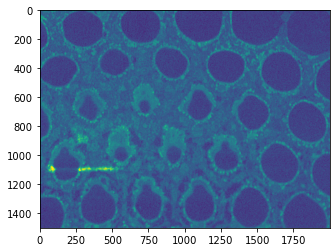

Device: cuda:0

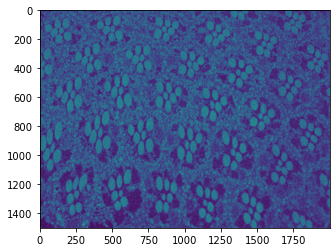


Device: cuda:1time taken for assigning  image:
 time taken for assigning  image:000000_000000_000015_000000.tif 
000000_000000_000486_000000.tifExecution time: 1.80 seconds

Execution time: 1.78 seconds(this iteration is with g value, 100 ,for the image:,000000_000000_000015_000000.tif, on Device: cuda:0

(this iteration is with g value, 100 ,for the image:,000000_000000_000486_000000.tif, on Device: cuda:1
A100-SXM4-40GB - 1564620000653 - Utilization: 0% - Timestamp: 2023-03-18 09:52:22
A100-SXM4-40GB - 1564520013405 - Utilization: 100% - Timestamp: 2023-03-18 09:52:22
time taken for iteration 100
Execution time: 84.70 seconds
######################################################################
(this iteration is with g value, 99 ,for the image:,000000_000000_000015_000000.tif, on Device: cuda:0
A100-SXM4-40GB - 1564620000653 - Utilization: 100% - Timestamp: 2023-03-18 09:52:56
A100-SXM4-40GB - 1564520013405 - Utilization: 10% - Timestamp: 2023-03-18 09:52:56
time taken for iterati

In [ ]:

def run(rank, size):
    # Set the CUDA device for this process
    torch.cuda.set_device(rank)
    # Add a print statement here to see the value of rank
    print(f"Rank: {rank}")#################################################################DEBugging
    
    success = False  # Set default value for success
    success_count=0
    starttime()#################################################################################time
    image_files = sorted([os.path.join(s,z) for z in os.listdir(s) if z.endswith("tif")])
    
    # Split the list of image files across all processes (GPUs)
    chunk_size = len(image_files) // size
    start_index = rank * chunk_size
    end_index = start_index + chunk_size if rank < size - 1 else len(image_files)
    
    print ('time for assigining ranks of the gpu :')
    endtime()##################################################################################time
    # Process images assigned to this process (GPU)
    for i in range(start_index,end_index):
            img=mh.imread(image_files[i])
            name_only = os.path.basename(image_files[i])
            #print(name_only)
            starttime()###################################################################time
            print(name_only)
            plt.imshow(img)
            plt.show()              
            #print (z)
            #a =img.shape           
            #plt.imshow(img)
            #plt.show()
            #img = torch.from_numpy(img).to('cuda')
            #b = img.copy()
            #b = torch.from_numpy(b)
            # Move input data to GPU
            #b = b.to('cuda')

            success = False
            device=torch.device(f'cuda:{rank}')
            # Add a print statement here to see the value of device
            print(f"Device: {device}")
            
            print ('time taken for assigning  image:',name_only)
            endtime()#####################################################################TIME
            
            for g in range(100, 0, -1):
                starttime()##############################################################TIME
                # Initialize NVML
                pynvml.nvmlInit()#####################################              GPU START
                b = img.copy()
                b = torch.from_numpy(b)
                # Move input data to GPU
                print (f"(this iteration is with g value, {g} ,for the image:,{name_only}, on Device: {device}")
                b = b.to('cuda')
                b.masked_fill_(b < g, 0)
                # Label the regions in the filtered image
                # Convert PyTorch tensor to numpy array
                b_np = b.cpu().numpy()

                # Find connected components in the image
                labeled, number = scipy.ndimage.label(b_np)

                # Convert labeled regions back to PyTorch tensor
                labeled = torch.from_numpy(labeled).to(b.device)                

                number = labeled.max().item()


                # filter based on labeled region size
                sizes = torch.bincount(labeled.view(-1))
                 # Remove the regions that are less than 1500
                too_small = (sizes < 1500).nonzero(as_tuple=True)[0]
                labeled_only_big = labeled.clone()
                for i in too_small:
                    labeled_only_big[labeled == i] = 0

                # Get the number of GPUs
                device_count = pynvml.nvmlDeviceGetCount()########################             GPU

                # Create a binary mask from the filtered labeled regions
                binary_mask = (labeled_only_big > 0).float()
                number_1 = binary_mask.max().item()

                # Close the regions in the binary mask
                kernel_size=3
                kernel=torch.ones((kernel_size,kernel_size),device=binary_mask.device)

                binary_mask_closed=F.conv2d(binary_mask[None,None,...],kernel[None,None,...],padding=kernel_size//2)>0

                #binary_mask_closed_filtered=F.gaussian_filter(binary_mask_closed.float(),sigma=3) 
                binary_mask_closed_filtered=(binary_mask_closed)
                binary_mask_closed_filtered = binary_mask_closed_filtered.to(torch.float32)




                # Move tensor from GPU to CPU and convert to NumPy array
                binary_mask_closed_filtered_np = binary_mask_closed_filtered.cpu().numpy()
                ###edited               

                #changed this line check  ----ref for debugging
                #labeled,number_final= label(binary_mask_closed_filtered.cpu())
                labeled,number_final= label(binary_mask_closed_filtered_np)


                # Apply binary threshold to the image to segment the regions of interest                    
                threshold=binary_mask_closed_filtered.flatten().kthvalue(int(binary_mask_closed_filtered.numel()*0.5))[0]                     
                binary_image=binary_mask_closed_filtered>threshold   


                 ###edited               

                #changed this line check  ----ref for debugging
                # Move tensor from GPU to CPU and convert to NumPy array
                binary_image_np = binary_image.cpu().numpy()
                labeled,num_regions= label(binary_image_np)#, return_num=True)

                #closed this line and replaced with abovr --- ref for debugging
                #labeled,num_regions= label(binary_image)#, return_num=True)

                region_sizes=[(labeled==i+1).sum() for i in range(num_regions)]

                min_region_size=5000

                large_regions_counted=sum([size>min_region_size for size in region_sizes])


                # Iterate over the region sizes and count the number of large regions

                for region_size in region_sizes:
                    if region_size > min_region_size:
                        large_regions_counted += 1
                        #print(large_regions_counted)


                binary_image_np = binary_image.cpu().numpy() 
                binary_image_np = binary_image_np.reshape(binary_image_np.shape[2], binary_image_np.shape[3])
                #print (z)

                # Loop over each GPU and get its utilization rate   ####################GPU
                for i in range(device_count):
                    handle = pynvml.nvmlDeviceGetHandleByIndex(i)
                    name = pynvml.nvmlDeviceGetName(handle)
                    serial = pynvml.nvmlDeviceGetSerial(handle)
                    util = pynvml.nvmlDeviceGetUtilizationRates(handle)
                    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
                    print(f"{name} - {serial} - Utilization: {util.gpu}% - Timestamp: {timestamp}")
                    #print(f"{name.decode()} - Utilization: {util.gpu}% - Timestamp: {time.strftime()}")

                # Shut down NVML
                pynvml.nvmlShutdown()##############################################GPU
                print('time taken for iteration',g)
                endtime()#########################################################################TIME
                # plt.imshow(binary_image_np)
                #plt.show()
                #print (number_1," <=50 and number_1 >=25 ")
                #print(large_regions, ">= 2")
                print ("######################################################################")

                if number_1 <=150 and number_1 >=100:
                    if large_regions_counted <=30:
                        success=True
                        print ("######################################################################")
                        plt.imshow(binary_image_np)
                        plt.show()
                        #print(f'success: {success}')
                        percent_success=(success_count/len(os.listdir(cropped)))*100
                        print(f'percent_success: {percent_success}')
                        #print(f'large_regions_counted: {large_regions_counted}')
                        print ('number_1',number_1)
                        print ("######################################################################")

                        break       


            if success==True:
                #print (z)
                plt.imshow(binary_image)
                plt.show()
                print (number_1," <=50 and number_1 >=25 ")
                print(large_regions, ">= 2")
                print ("######################################################################")
                #shutil.move(os.path.join(normalized,z),os.path.join(originals,z))                 
                #shutil.move(os.path.join(cropped,z),os.path.join(masks,z))                 
                #mh.imsave(os.path.join(masks,z),binary_image)                 
                success_count+=1        
                percent_success=(success_count/len(os.listdir(dir)))*100        
                if percent_success>=50 and percent_success<100:
                     print('50% Success')                
                elif percent_success==100:
                     print('100% Success')
    pass

def init_process(rank, size, fn, backend='gloo'):
    """Initialize the distributed environment."""
    os.environ['MASTER_ADDR'] = '127.0.0.1'
    os.environ['MASTER_PORT'] = '29500'
    dist.init_process_group(backend, rank=rank, world_size=size)
    fn(rank, size)

if __name__ == "__main__":
    # Set the start method for multiprocessing
   # multiprocessing.set_start_method('spawn')
    size = 2 # Number of processes (GPUs) to use
    processes = []
    for rank in range(size):
        p = Process(target=init_process, args=(rank, size, run))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()


